In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    Concatenate, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



In [58]:
# 衛星画像を読み込み。
path_b03 = '/content/drive/MyDrive/250909_B03c/*.jpg'
path_b13 = '/content/drive/MyDrive/250909_B13c/*.jpg'

# b3画像の読み込みと正規化
X1 = []
X2 = []

for p in sorted(glob.glob(path_b03)):
    image = Image.open(p).convert('L')
    X1.append(np.array(image))

for p in sorted(glob.glob(path_b13)):
    image = Image.open(p).convert('L')
    X2.append(np.array(image))

X1 = (X1 - np.mean(X1)) / (np.max(X1) - np.min(X1))
X2 = (X2 - np.mean(X2)) / (np.max(X2) - np.min(X2))

X = np.stack([X1, X2], axis=3)
X = X[:360]

In [ ]:
# 画像情報の確認

print(np.array(X).shape)
plt.imshow(X[5,50:150,:,0])  #5枚目の画像、Y方向50:150, X方向全部、最初のバンドを表示。

In [68]:
# 環境情報データをデータフレーム格納。

df = pd.read_csv(
    '/content/drive/MyDrive/kisho_kochi.csv',
    encoding='shift_jis',
    parse_dates=['年月日時'],
    index_col='年月日時'
)
y = np.array(df["日射量"], dtype=np.float32)               #目的変数
w1 = np.array(df["晴天時日射量"], dtype=np.float32)        #説明変数
w1 = (w1 - np.mean(w1)) / (np.max(w1) - np.min(w1) + 1e-6)
w = w1

y = y[0:360]
w = w[0:360]

In [ ]:
# 環境情報の確認
print(df[:20])

In [ ]:
# 晴天時日射量と実際の日射量の相関

plt.figure(figsize=(6, 6))
plt.scatter(df["日射量"], df["晴天時日射量"], color='blue', label='Data')

# y = x の赤い点線を追加
min_val = min(df["日射量"].min(), df["晴天時日射量"].min())
max_val = max(df["日射量"].max(), df["晴天時日射量"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel('Calcurated PPFD')
plt.ylabel('Real PPFD')
plt.legend()
plt.show()


In [79]:
# 昼のデータだけを対象とする。
#mask = (y > 0.1)
#X = X[mask]
#y = y[mask]
#w = w[mask]

#X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(X, y, z, test_size=0.2, random_state=42)

# 前66% → train、後33% → val
n = len(X)
split_idx = int(n * 0.66)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]
w_train, w_val = w[:split_idx], w[split_idx:]

In [62]:
# 画像特徴と数値情報を融合した軽量CNN回帰ネットワーク

# 画像の畳み込み
image_input = Input(shape=(200,400, 2))
x = Conv2D(8, (3, 3), activation='relu', padding='same', dilation_rate=5)(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', dilation_rate=5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(8, activation='relu')(x)

# 数値データのNN
meta_input = Input(shape=(1,))    #インプットデータのshapeに合わせる
m = Dense(8, activation='relu')(meta_input)
m = Dense(8, activation='relu')(m)

# 画像と数値を結合
combined = Concatenate()([x, m])
output = Dense(1, activation='linear')(combined)

# モデル構築
model = Model(inputs=[image_input, meta_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')


In [ ]:
# モデル学習
history = model.fit(
    [X_train, w_train], y_train,
    validation_data=([X_val, w_val], y_val),
    epochs=5,
    batch_size=8
)

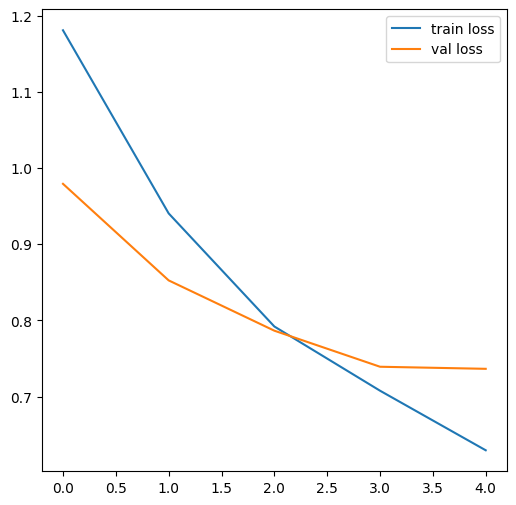

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step


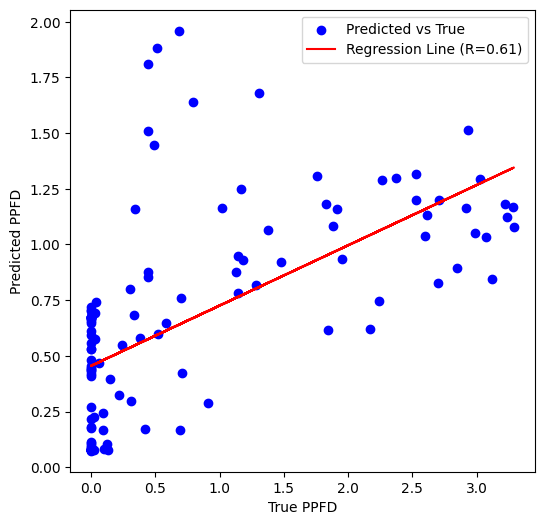

In [90]:
# 学習曲線
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# 予測値
y_pred = model.predict([X_val,z_val]).flatten()

# 相関係数
r_value = np.corrcoef(y_val, y_pred)[0, 1]

# 回帰直線
reg_model = LinearRegression()
reg_model.fit(y_val.reshape(-1, 1), y_pred)
reg_line = reg_model.predict(y_val.reshape(-1, 1))

# 描画
plt.figure(figsize=(6, 6))
plt.scatter(x=y_val, y=y_pred, color='blue', label='Predicted vs True')
plt.plot(y_val, reg_line, color='red', label=f'Regression Line (R={r_value:.2f})')
plt.xlabel('True PPFD')
plt.ylabel('Predicted PPFD')
plt.legend()
plt.show()

In [ ]:
# 時系列結果の表示
y_pred = model.predict([X_val,w_val]).flatten()
time_index = np.arange(len(y_val))

# グラフの描画
plt.figure(figsize=(10, 4))
plt.plot(time_index, y_val, label='True PPFD', color='blue', linewidth=2)
plt.plot(time_index, y_pred, label='Predicted PPFD', color='orange', linestyle='--', linewidth=2)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

y_pred = model.predict([X,w]).flatten()
time_index = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.plot(time_index, y, label='True PPFD', color='blue', linewidth=2)
plt.plot(time_index, y_pred, label='Predicted PPFD', color='orange', linestyle='--', linewidth=2)


In [87]:
len(y_pred)

360